In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from gnninterpreter import *

In [3]:
import torch

# Motif

In [4]:
dataset = MotifDataset(seed=12345)

data: Data(x=[20, 5], edge_index=[2, 52], y=[1], G=Graph named 'House Graph' with 20 nodes and 26 edges)
class: house


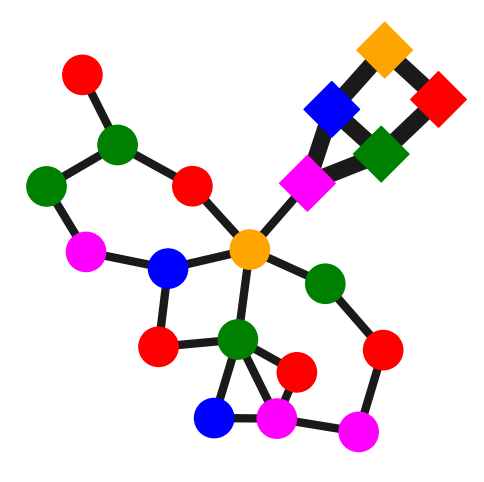

In [5]:
dataset.show(0)

In [6]:
model = GCNClassifier(node_features=len(dataset.NODE_CLS),
                      num_classes=len(dataset.GRAPH_CLS),
                      hidden_channels=64,
                      num_layers=3)
model.load_state_dict(torch.load('ckpts/motif.pt'))

<All keys matched successfully>

In [7]:
dataset_list_gt = dataset.split_by_class()
dataset_list_pred = dataset.split_by_pred(model)

/opt/homebrew/Caskroom/mambaforge/base/envs/gnninterpreter/lib/python3.10/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. The data of the dataset is already cached, so any modifications to `data` will not be reflected when accessing its elements. Clearing the cache now by removing all elements in `dataset._data_list`. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/opt/homebrew/Caskroom/mambaforge/base/envs/gnninterpreter/lib/python3.10/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you ar

In [8]:
evaluation = dataset.model_evaluate(model)
evaluation

{'acc': 0.999566376209259,
 'cm': array([[2299,    1,    0,    3,    0],
        [   1, 2212,    0,    0,    0],
        [   0,    0, 2271,    0,    0],
        [   0,    0,    0, 2404,    0],
        [   0,    0,    0,    0, 2340]]),
 'f1': {'partial': 0.9989137649536133,
  'house': 0.9995481371879578,
  'house_x': 1.0,
  'comp_4': 0.9993764162063599,
  'comp_5': 1.0}}

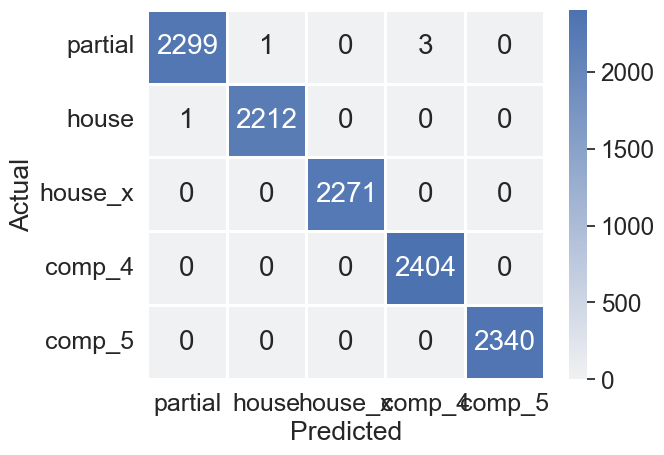

In [9]:
draw_matrix(evaluation['cm'], dataset.GRAPH_CLS.values(), fmt='d')

In [10]:
mean_embeds = [d.model_transform(model, key="embeds").mean(dim=0) for d in dataset_list_gt]

/opt/homebrew/Caskroom/mambaforge/base/envs/gnninterpreter/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [11]:
trainer = {}
sampler = {}

# House

In [68]:
cls_idx = 1
trainer[cls_idx] = Trainer(
    sampler=(s := GraphSampler(
        max_nodes=30,
        num_node_cls=len(dataset.NODE_CLS),
        temperature=0.2,
        learn_node_feat=True
    )),
    discriminator=model,
    criterion=WeightedCriterion([
        dict(key="logits", criterion=ClassScoreCriterion(class_idx=cls_idx, mode='maximize'), weight=50),
        dict(key="logits", criterion=ClassScoreCriterion(class_idx=0, mode='minimize'), weight=50),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_idx]), weight=0),
        dict(key="logits", criterion=MeanPenalty(), weight=0),
        dict(key="omega", criterion=NormPenalty(order=1), weight=1),
        dict(key="omega", criterion=NormPenalty(order=2), weight=1),
        dict(key="xi", criterion=NormPenalty(order=1), weight=0),
        dict(key="xi", criterion=NormPenalty(order=2), weight=0),
        # dict(key="eta", criterion=NormPenalty(order=1), weight=0),
        # dict(key="eta", criterion=NormPenalty(order=2), weight=0),
        dict(key="theta_pairs", criterion=KLDivergencePenalty(binary=True), weight=1),
    ]),
    optimizer=(o := torch.optim.SGD(s.parameters(), lr=1)),
    scheduler=torch.optim.lr_scheduler.ExponentialLR(o, gamma=1),
    dataset=dataset,
    budget_penalty=BudgetPenalty(budget=10, order=2, beta=1),
)

In [69]:
cls_idx = 1
trainer[cls_idx].train(
    iterations=2000,
    target_probs={cls_idx: (0.9, 1.0)},
    target_size=40,
    w_budget_init=1,
    w_budget_inc=1.1,
    w_budget_dec=0.98,
    k_samples=16
)

  0%|          | 0/2000 [00:00<?, ?it/s]

True

n=29 m=38
logits=[0.2703742980957031, 7.344586372375488, -55.47788619995117, -44.952728271484375, -24.62847137451172]
probs=[0.000845943228341639, 0.9991540908813477, 5.202112039414863e-28, 1.937303701475667e-23, 1.2999011453828854e-14]


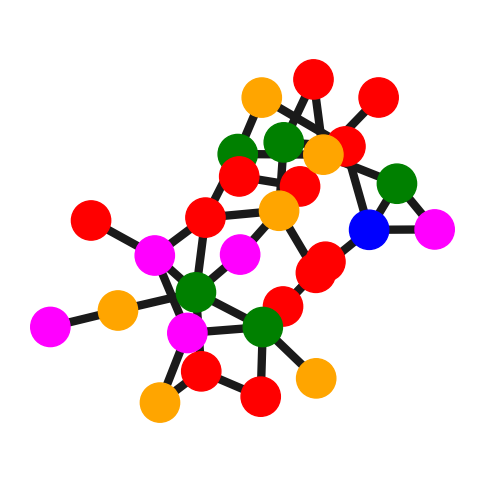

In [70]:
trainer[1].evaluate(threshold=0.5, show=True)

# House X

In [73]:
cls_idx = 2
trainer[cls_idx] = Trainer(
    sampler=(s := GraphSampler(
        max_nodes=30,
        num_node_cls=len(dataset.NODE_CLS),
        temperature=0.2,
        learn_node_feat=True
    )),
    discriminator=model,
    criterion=WeightedCriterion([
        dict(key="logits", criterion=ClassScoreCriterion(class_idx=cls_idx, mode='maximize'), weight=100),
        dict(key="logits", criterion=ClassScoreCriterion(class_idx=0, mode='minimize'), weight=50),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_idx]), weight=0),
        dict(key="logits", criterion=MeanPenalty(), weight=0),
        dict(key="omega", criterion=NormPenalty(order=1), weight=1),
        dict(key="omega", criterion=NormPenalty(order=2), weight=1),
        dict(key="xi", criterion=NormPenalty(order=1), weight=0),
        dict(key="xi", criterion=NormPenalty(order=2), weight=0),
        # dict(key="eta", criterion=NormPenalty(order=1), weight=0),
        # dict(key="eta", criterion=NormPenalty(order=2), weight=0),
        dict(key="theta_pairs", criterion=KLDivergencePenalty(binary=True), weight=1),
    ]),
    optimizer=(o := torch.optim.SGD(s.parameters(), lr=1)),
    scheduler=torch.optim.lr_scheduler.ExponentialLR(o, gamma=1),
    dataset=dataset,
    budget_penalty=BudgetPenalty(budget=10, order=2, beta=1),
)

In [77]:
cls_idx = 2
trainer[cls_idx].train(
    iterations=2000,
    target_probs={cls_idx: (0.9, 1.0)},
    target_size=80,
    w_budget_init=1,
    w_budget_inc=1.1,
    w_budget_dec=0.98,
    k_samples=16
)

 65%|######4   | 3709/5709 [00:00<?, ?it/s]

True

n=30 m=68
logits=[9.422897338867188, -79.77259826660156, 14.620230674743652, -30.579566955566406, -22.201568603515625]
probs=[0.005500867497175932, 1.007673725695976e-41, 0.9944990873336792, 2.331209516145813e-20, 1.0141442097669993e-16]


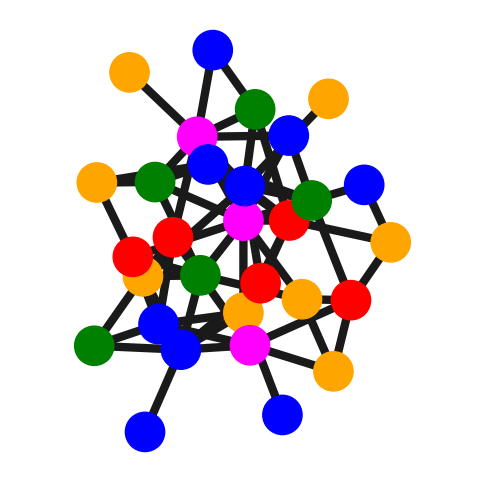

In [78]:
trainer[2].evaluate(threshold=0.5, show=True)

# Comp 4

In [79]:
cls_idx = 3
trainer[cls_idx] = Trainer(
    sampler=(s := GraphSampler(
        max_nodes=30,
        num_node_cls=len(dataset.NODE_CLS),
        temperature=0.2,
        learn_node_feat=True
    )),
    discriminator=model,
    criterion=WeightedCriterion([
        dict(key="logits", criterion=ClassScoreCriterion(class_idx=cls_idx, mode='maximize'), weight=100),
        dict(key="logits", criterion=ClassScoreCriterion(class_idx=0, mode='minimize'), weight=50),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_idx]), weight=0),
        dict(key="logits", criterion=MeanPenalty(), weight=0),
        dict(key="omega", criterion=NormPenalty(order=1), weight=1),
        dict(key="omega", criterion=NormPenalty(order=2), weight=1),
        dict(key="xi", criterion=NormPenalty(order=1), weight=0),
        dict(key="xi", criterion=NormPenalty(order=2), weight=0),
        # dict(key="eta", criterion=NormPenalty(order=1), weight=0),
        # dict(key="eta", criterion=NormPenalty(order=2), weight=0),
        dict(key="theta_pairs", criterion=KLDivergencePenalty(binary=True), weight=1),
    ]),
    optimizer=(o := torch.optim.SGD(s.parameters(), lr=1)),
    scheduler=torch.optim.lr_scheduler.ExponentialLR(o, gamma=1),
    dataset=dataset,
    budget_penalty=BudgetPenalty(budget=10, order=2, beta=1),
)

In [80]:
cls_idx = 3
trainer[cls_idx].train(
    iterations=2000,
    target_probs={cls_idx: (0.9, 1.0)},
    target_size=80,
    w_budget_init=1,
    w_budget_inc=1.1,
    w_budget_dec=0.98,
    k_samples=16
)

  0%|          | 0/2000 [00:00<?, ?it/s]

True

n=30 m=50
logits=[-1.524770736694336, -104.24006652832031, -26.30599594116211, 4.617589950561523, -36.640052795410156]
probs=[0.0021452305372804403, 0.0, 3.70787114119947e-14, 0.9978547692298889, 1.2053132014869966e-18]


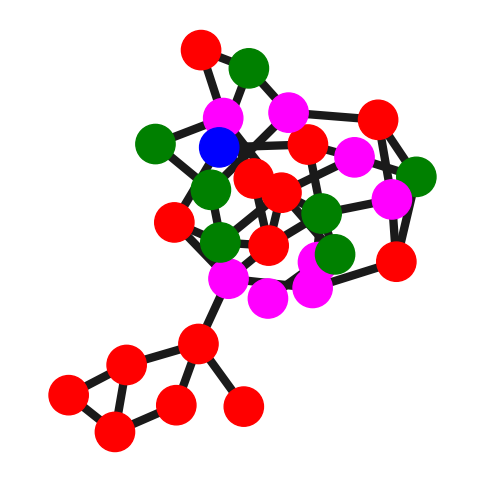

In [81]:
trainer[3].evaluate(threshold=0.5, show=True)

# Comp 5

In [12]:
cls_idx = 4
trainer[cls_idx] = Trainer(
    sampler=(s := GraphSampler(
        max_nodes=30,
        num_node_cls=len(dataset.NODE_CLS),
        temperature=0.2,
        learn_node_feat=True
    )),
    discriminator=model,
    criterion=WeightedCriterion([
        dict(key="logits", criterion=ClassScoreCriterion(class_idx=cls_idx, mode='maximize'), weight=100),
        dict(key="logits", criterion=ClassScoreCriterion(class_idx=0, mode='minimize'), weight=100),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_idx]), weight=0),
        dict(key="logits", criterion=MeanPenalty(), weight=0),
        dict(key="omega", criterion=NormPenalty(order=1), weight=1),
        dict(key="omega", criterion=NormPenalty(order=2), weight=1),
        dict(key="xi", criterion=NormPenalty(order=1), weight=0),
        dict(key="xi", criterion=NormPenalty(order=2), weight=0),
        # dict(key="eta", criterion=NormPenalty(order=1), weight=0),
        # dict(key="eta", criterion=NormPenalty(order=2), weight=0),
        dict(key="theta_pairs", criterion=KLDivergencePenalty(binary=True), weight=0),
    ]),
    optimizer=(o := torch.optim.SGD(s.parameters(), lr=1)),
    scheduler=torch.optim.lr_scheduler.ExponentialLR(o, gamma=1),
    dataset=dataset,
    budget_penalty=BudgetPenalty(budget=10, order=2, beta=1),
)

In [13]:
cls_idx = 4
trainer[cls_idx].train(
    iterations=2000,
    target_probs={cls_idx: (0.9, 1.0)},
    target_size=80,
    w_budget_init=1,
    w_budget_inc=1.1,
    w_budget_dec=0.98,
    k_samples=16
)

  0%|          | 0/2000 [00:00<?, ?it/s]

True

n=28 m=64
logits=[14.535619735717773, -225.2082977294922, -69.43289184570312, -214.0039825439453, 28.116111755371094]
probs=[1.2649304608203238e-06, 0.0, 4.3159992701204366e-43, 0.0, 0.9999986886978149]


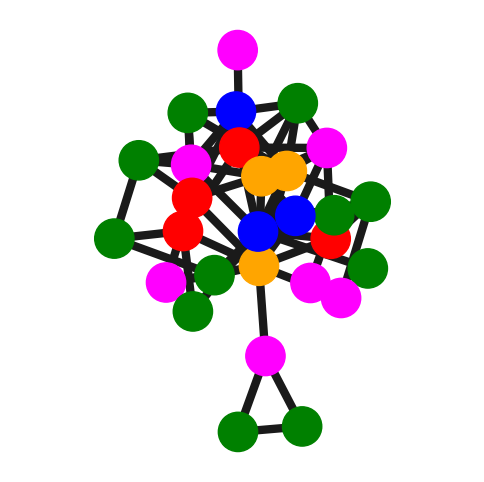

In [14]:
trainer[4].evaluate(threshold=0.5, show=True)